In [1]:
import enum
import typing
import itertools
import dataclasses
from pathlib import Path

import attrs
import numpy as np
from IPython import display

from arc25.dsl import types, primitives
from arc25.dsl import api as dsl
from arc25 import tools, dataset

In [2]:
proj_root = Path("..").resolve()
data_path = proj_root / "data"
db_root = data_path / "solutions"
challenges_root = data_path / "arc-prize-2025.zip"

In [3]:
print(", ".join(types.__all__))

AnyImage, Axis4, Axis8, Canvas, Color, ColorArray, Coord, Dir4, Dir8, Image, Mask, MaskedImage, Paintable, Pattern, ShapeSpec, Transform


In [4]:
print(", ".join(primitives.__all__))

advance_pattern, cell_count, count_colors, dilate, erode, extract_image, fill, make_canvas, mask_all, mask_col, mask_color, mask_none, mask_row, masks_touch, most_common_color, new_mask_like, paste, path_ray, path_segment, path_span, path_to_mask, pattern_cycle, pattern_dotted, pattern_solid, stroke, transform


In [5]:
print(", ".join(dsl.__all__))

AnyImage, Axis4, Axis8, Canvas, Color, ColorArray, Coord, Dir4, Dir8, Image, Mask, MaskedImage, Paintable, Pattern, ShapeSpec, Transform, advance_pattern, cell_count, count_colors, dilate, erode, extract_image, fill, make_canvas, mask_all, mask_col, mask_color, mask_none, mask_row, masks_touch, most_common_color, new_mask_like, paste, path_ray, path_segment, path_span, path_to_mask, pattern_cycle, pattern_dotted, pattern_solid, stroke, transform, ROW, DIAG_ANTI, COL, DIAG_MAIN, ROW, COL, RIGHT, UP_RIGHT, UP, UP_LEFT, LEFT, DOWN_LEFT, DOWN, DOWN_RIGHT, RIGHT, UP, LEFT, DOWN, BLACK, BLUE, RED, GREEN, YELLOW, GRAY, MAGENTA, ORANGE, CYAN, BROWN, IDENTITY, FLIP_LR, FLIP_UD, ROTATE_180, FLIP_DIAG_MAIN, ROTATE_LEFT, ROTATE_RIGHT, FLIP_DIAG_ANTI


In [6]:
datasets = {}
for k in ["training", "evaluation", "test"]:
    datasets[k] = await dataset.Dataset.load(
        id=k,
        root=challenges_root,
        challenges=f"arc-agi_{k}_challenges.json",
        solutions=f"arc-agi_{k}_solutions.json" if k != "test" else None,
    )
ds = datasets["combined"] = dataset.Dataset(
    id="combined",
    challenges = dict(itertools.chain(*[ds.challenges.items() for ds in datasets.values()])),
)

In [11]:
solutions = await dataset.SolutionDB.load(db_root)
sol_with_code = sorted(k for k,v in solutions.solutions.items() if v.rule)
print(len(solutions.solutions), len(sol_with_code))

7 3


In [12]:
ckey = sol_with_code[0]

sol = solutions.solutions[ckey]
print(f"Challenbge {ckey}:")
print("Explanation:")
display.display(display.Markdown(sol.explanation))
print("Rule:")
display.display(display.Code(sol.rule, language="python"))


Challenbge 00576224:
Explanation:


- Output is a 3 by 3 tiling of the input.
- Middle row of tiles are horizontally flipped.


Rule:


def solution(input: Canvas) -> Canvas:
    # prepare output
    output = make_canvas(6,6)
    for tile_row in range(3):
        tile = input
        # flip tile for middle row (row 1)
        if tile_row == 1:
            tile = transform(tile, FLIP_LR)
        for tile_col in range(3):
            output = paste(output, tile, at=(2*tile_row, 2*tile_col))
    return output

Score on train: 2/2 (100 %)
Score on test: 0/0 (nan %)


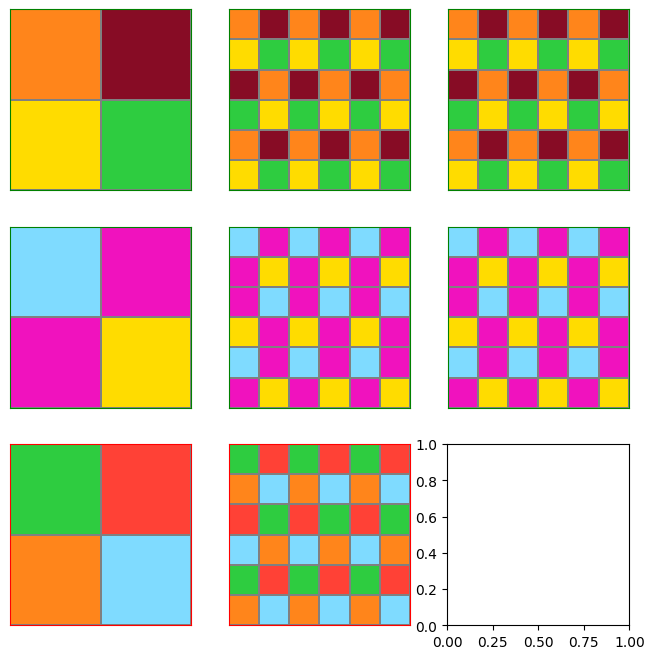

In [13]:
chal = ds.challenges[ckey]
triples = []
score = dict(train=[],test=[])
for eset in ["train","test"]:
    for io in getattr(chal,eset):
        glob = {k:getattr(dsl,k) for k in dsl.__all__}
        loc = dict()
        exec(sol.rule,globals=glob,locals=loc)
        solver = loc["solution"]
        actual = solver(io.input)
        assert actual is not None
        assert isinstance(actual, types.Canvas)
        if isinstance(actual.image, types.MaskedImage):
            assert np.all(actual.image._mask)
            actual = dataclasses.replace(actual, image=types.Image(_data=actual.image._data))
        if io.output is not None:
            score[eset].append(np.mean(actual.image._data == io.output.image._data))
        triples.append(io.compare_output(actual))
for k,v in score.items():
    print(f"Score on {k}: {sum(vv==1 for vv in v)}/{len(v)} ({np.mean(v)*100:.0f} %)")
tools.show_test_case(
    triples,
    n_train = len(chal.train),
    width = 8,
)

In [10]:
actual

Canvas(image=Image(_data=array([[3, 2, 3, 2, 3, 2],
       [7, 8, 7, 8, 7, 8],
       [3, 2, 3, 2, 3, 2],
       [7, 8, 7, 8, 7, 8],
       [3, 2, 3, 2, 3, 2],
       [7, 8, 7, 8, 7, 8]])), orientation=<SymOp.e: 0>)